# Classification with an Academic Success Dataset

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
f = open("/content/drive/MyDrive/Kaggle/Classification with an Academic Success Dataset/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [ ]:
!kaggle competitions download -c playground-series-s4e6

  0% 0.00/3.07M [00:00<?, ?B/s]
100% 3.07M/3.07M [00:00<00:00, 139MB/s]


In [ ]:
!unzip playground-series-s4e6.zip

Archive:  playground-series-s4e6.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## 1. Imports and Configs

In [ ]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
#!pip install gap-stat
#from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
!pip install optuna
import optuna
#!pip install cmaes
#import cmaes
import xgboost as xgb
!pip install catboost
#!pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingRegressor
#!pip install -U imbalanced-learn
#from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
SEED = 23
N_FOLDS = 5
target = 'Target'

## 2. Data Loading and Overview

In [ ]:
global device
device = 'cpu'

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv("sample_submission.csv")

train_copy=train.copy()
test_copy=test.copy()

train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)

train.reset_index(inplace=True,drop=True)

initial_features = list(train.columns)

In [ ]:
train

Marital status  Application mode  Application order  Course  \
0                   1                 1                  1    9238   
1                   1                17                  1    9238   
2                   1                17                  2    9254   
3                   1                 1                  3    9500   
4                   1                 1                  2    9500   
...               ...               ...                ...     ...   
76513               1                17                  1    9254   
76514               1                 1                  6    9254   
76515               5                17                  1    9085   
76516               1                 1                  3    9070   
76517               1                 1                  1    9773   

       Daytime/evening attendance  Previous qualification  \
0                               1                       1   
1                               1                       1   
2                               1                       1   
3                               1                       1   
4                               1                       1   
...                           ...                     ...   
76513                           1                       1   
76514                           1                       1   
76515                           1                       1   
76516                           1                       1   
76517                           1                       1   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
0                               126.0            1                       1   
1                               125.0            1                      19   
2                               137.0            1                       3   
3                               131.0            1                      19   
4                               132.0            1                      19   
...                               ...          ...                     ...   
76513                           121.0            1                      19   
76514                           125.0            1                       1   
76515                           138.0            1                      37   
76516                           136.0            1                      38   
76517                           133.1            1                      19   

       Father's qualification  Mother's occupation  Father's occupation  \
0                          19                    5                    5   
1                          19                    9                    9   
2                          19                    2                    3   
3                           3                    3                    2   
4                          37                    4                    9   
...                       ...                  ...                  ...   
76513                       1                    7                    5   
76514                      38                    4                    9   
76515                      37                    9                   10   
76516                      37                    5                    9   
76517                      19                    4                    9   

       Admission grade  Displaced  Educational special needs  Debtor  \
0                122.6          0                          0       0   
1                119.8          1                          0       0   
2                144.7          0                          0       0   
3                126.1          1                          0       0   
4                120.1          1                          0       0   
...                ...        ...                        ...     ...   
76513            116.5          1                          0       0   
76514            13

In [ ]:
train.isna().sum().sort_values(ascending=False)

Marital status                                    0
Age at enrollment                                 0
Curricular units 1st sem (credited)               0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (approved)               0
Curricular units 1st sem (grade)                  0
Curricular units 1st sem (without evaluations)    0
Curricular units 2nd sem (credited)               0
Curricular units 2nd sem (enrolled)               0
Curricular units 2nd sem (evaluations)            0
Curricular units 2nd sem (approved)               0
Curricular units 2nd sem (grade)                  0
Curricular units 2nd sem (without evaluations)    0
Unemployment rate                                 0
Inflation rate                                    0
GDP                                               0
International                                     0
Scholarship holder                                0
Application 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                 

In [ ]:
train.duplicated().sum()

0

In [ ]:
train.describe().T

count         mean  \
Marital status                                  76518.0     1.111934   
Application mode                                76518.0    16.054419   
Application order                               76518.0     1.644410   
Course                                          76518.0  9001.286377   
Daytime/evening attendance                      76518.0     0.915314   
Previous qualification                          76518.0     3.658760   
Previous qualification (grade)                  76518.0   132.378766   
Nacionality                                     76518.0     1.226600   
Mother's qualification                          76518.0    19.837633   
Father's qualification                          76518.0    23.425076   
Mother's occupation                             76518.0     8.583196   
Father's occupation                             76518.0     8.882172   
Admission grade                                 76518.0   125.363971   
Displaced                                       76518.0     0.569265   
Educational special needs                       76518.0     0.003738   
Debtor                                          76518.0     0.071382   
Tuition fees up to date                         76518.0     0.893646   
Gender                                          76518.0     0.315821   
Scholarship holder                              76518.0     0.247393   
Age at enrollment                               76518.0    22.278653   
International                                   76518.0     0.006626   
Curricular units 1st sem (credited)             76518.0     0.188871   
Curricular units 1st sem (enrolled)             76518.0     5.891516   
Curricular units 1st sem (evaluations)          76518.0     7.352362   
Curricular units 1st sem (approved)             76518.0     4.178520   
Curricular units 1st sem (grade)                76518.0     9.995862   
Curricular units 1st sem (without evaluations)  76518.0     0.057960   
Curricular units 2nd sem (credited)             76518.0     0.137053   
Curricular units 2nd sem (enrolled)             76518.0     5.933414   
Curricular units 2nd sem (evaluations)          76518.0     7.234468   
Curricular units 2nd sem (approved)             76518.0     4.007201   
Curricular units 2nd sem (grade)                76518.0     9.626085   
Curricular units 2nd sem (without evaluations)  76518.0     0.062443   
Unemployment rate                               76518.0    11.520340   
Inflation rate                                  76518.0     1.228218   
GDP                                             76518.0    -0.080921   

                                                        std    min  \
Marital status                                     0.441669   1.00   
Application mode                                  16.682337   1.00   
Application order                                  1.229645   0.00   
Course                                          1803.438531  33.00   
Daytime/evening attendance                         0.278416   0.00   
Previous qualification                             8.623774   1.00   
Previous qualification (grade)                    10.995328  95.00   
Nacionality                                        3.392183   1.00   
Mother's qualification                            15.399456   1.00   
Father's qualification                            14.921164   1.00   
Mother's occupation                               17.471591   0.00   
Father's occupation                               16.803940   0.00   
Admission grade                                   12.562328  95.00   
Displaced                                          0.495182   0.00   
Educational special needs                          0.061023   0.00   
Debtor                                             0.257463   0.00   
Tuition fees up to date                            0.308292   0.00   
Gender                                             0.464845   0.00   
Scholarship holder                                 0.43

In [ ]:
test

Marital status  Application mode  Application order  Course  \
0                   1                 1                  1    9500   
1                   1                 1                  1    9238   
2                   1                 1                  1    9238   
3                   1                44                  1    9147   
4                   1                39                  1    9670   
...               ...               ...                ...     ...   
51007               1                 1                  2     171   
51008               2                39                  1    9119   
51009               1                 1                  1     171   
51010               1                 1                  3    9773   
51011               1                 1                  1     171   

       Daytime/evening attendance  Previous qualification  \
0                               1                       1   
1                               1                       1   
2                               1                       1   
3                               1                      39   
4                               1                       1   
...                           ...                     ...   
51007                           1                       1   
51008                           1                      19   
51009                           1                       1   
51010                           1                       1   
51011                           1                       1   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
0                               141.0            1                       3   
1                               128.0            1                       1   
2                               118.0            1                       1   
3                               130.0            1                       1   
4                               110.0            1                       1   
...                               ...          ...                     ...   
51007                           128.0            1                      38   
51008                           133.1            1                      19   
51009                           127.0            1                       1   
51010                           132.0            1                      19   
51011                           129.0            1                      37   

       Father's qualification  Mother's occupation  Father's occupation  \
0                           1                    2                    3   
1                          19                    4                    5   
2                          19                    4                    9   
3                          19                    3                    3   
4                          37                    5                    5   
...                       ...                  ...                  ...   
51007                      37                    7                   10   
51008                      37                    9                    9   
51009                       1                    4                   10   
51010                      19                    5                    5   
51011                      38                    9                    9   

       Admission grade  Displaced  Educational special needs  Debtor  \
0                152.1          0                          0       0   
1                116.5          0                          0       0   
2                114.2          0                          0       0   
3                130.0          0                          0       0   
4                106.0          1                          0       0   
...                ...        ...                        ...     ...   
51007            124.7          1                          0       0   
51008            14

## 3. Exploratory Data Analysis

In [ ]:
for col in train.columns:
    print(col)

Marital status
Application mode
Application order
Course
Daytime/evening attendance
Previous qualification
Previous qualification (grade)
Nacionality
Mother's qualification
Father's qualification
Mother's occupation
Father's occupation
Admission grade
Displaced
Educational special needs
Debtor
Tuition fees up to date
Gender
Scholarship holder
Age at enrollment
International
Curricular units 1st sem (credited)
Curricular units 1st sem (enrolled)
Curricular units 1st sem (evaluations)
Curricular units 1st sem (approved)
Curricular units 1st sem (grade)
Curricular units 1st sem (without evaluations)
Curricular units 2nd sem (credited)
Curricular units 2nd sem (enrolled)
Curricular units 2nd sem (evaluations)
Curricular units 2nd sem (approved)
Curricular units 2nd sem (grade)
Curricular units 2nd sem (without evaluations)
Unemployment rate
Inflation rate
GDP
Target


In [ ]:
for col in train.columns:
    print(f'{col} has {train[col].nunique()} values')

Marital status has 6 values
Application mode has 22 values
Application order has 8 values
Course has 19 values
Daytime/evening attendance has 2 values
Previous qualification has 21 values
Previous qualification (grade) has 110 values
Nacionality has 18 values
Mother's qualification has 35 values
Father's qualification has 39 values
Mother's occupation has 40 values
Father's occupation has 56 values
Admission grade has 668 values
Displaced has 2 values
Educational special needs has 2 values
Debtor has 2 values
Tuition fees up to date has 2 values
Gender has 2 values
Scholarship holder has 2 values
Age at enrollment has 46 values
International has 2 values
Curricular units 1st sem (credited) has 21 values
Curricular units 1st sem (enrolled) has 24 values
Curricular units 1st sem (evaluations) has 36 values
Curricular units 1st sem (approved) has 23 values
Curricular units 1st sem (grade) has 1206 values
Curricular units 1st sem (without evaluations) has 12 values
Curricular units 2nd sem

In [ ]:
num_cols = ['Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment','Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']

In [ ]:
print(len(num_cols))

9


In [ ]:
cat_cols = list(filter(lambda x: x not in num_cols, initial_features))

In [ ]:
print(len(cat_cols))

28


In [ ]:
print(cat_cols)

['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)', 'Target']


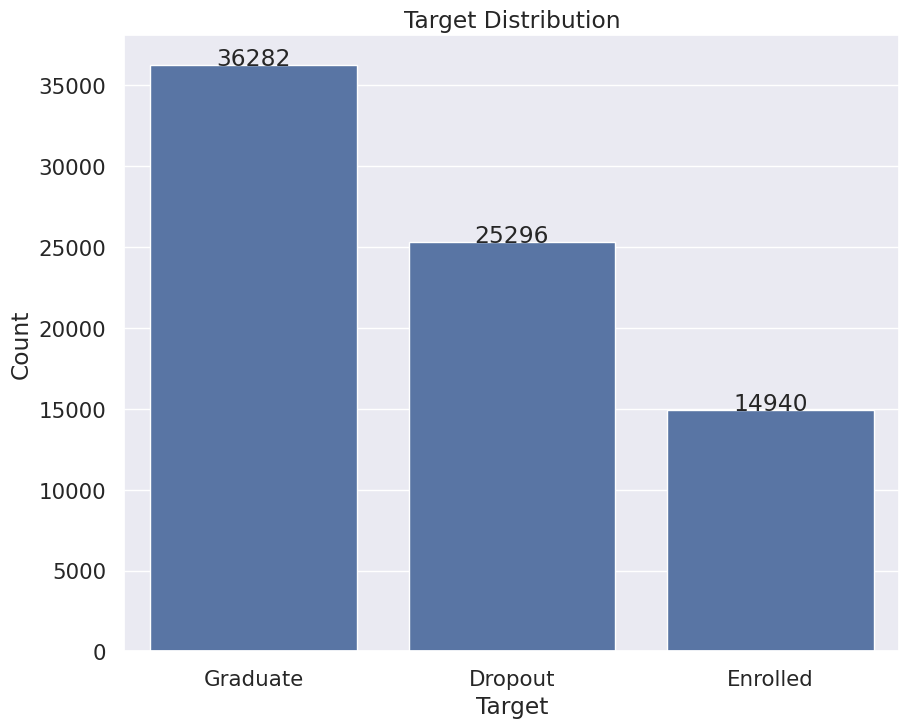

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Target', data=train)

# Add labels to each bar in the plot
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center")

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(48, 24), dpi = 150)

plotnumber = 1

for col in cat_cols:
    if plotnumber <= len(cat_cols):
        ax = plt.subplot(7, 4, plotnumber)
        sns.countplot(x=train[col], data=train)

        # Add labels to each bar in the plot
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center")

        plt.xlabel(col)
        # plt.xticks(rotation=45)

    plotnumber += 1

plt.suptitle('Distribution of Categorical Variables', fontsize=40, y=1)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(18, 18))
plotnumber = 1

for column in num_cols:
    if plotnumber <= len(num_cols):
        ax = plt.subplot(3, 3, plotnumber)
        sns.histplot(train[column])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        plt.xlabel(column)
        ax.grid(False)

    plotnumber += 1

plt.suptitle('Distribution of Numeric Variables', fontsize=40, y=1)
plt.tight_layout()
plt.show()

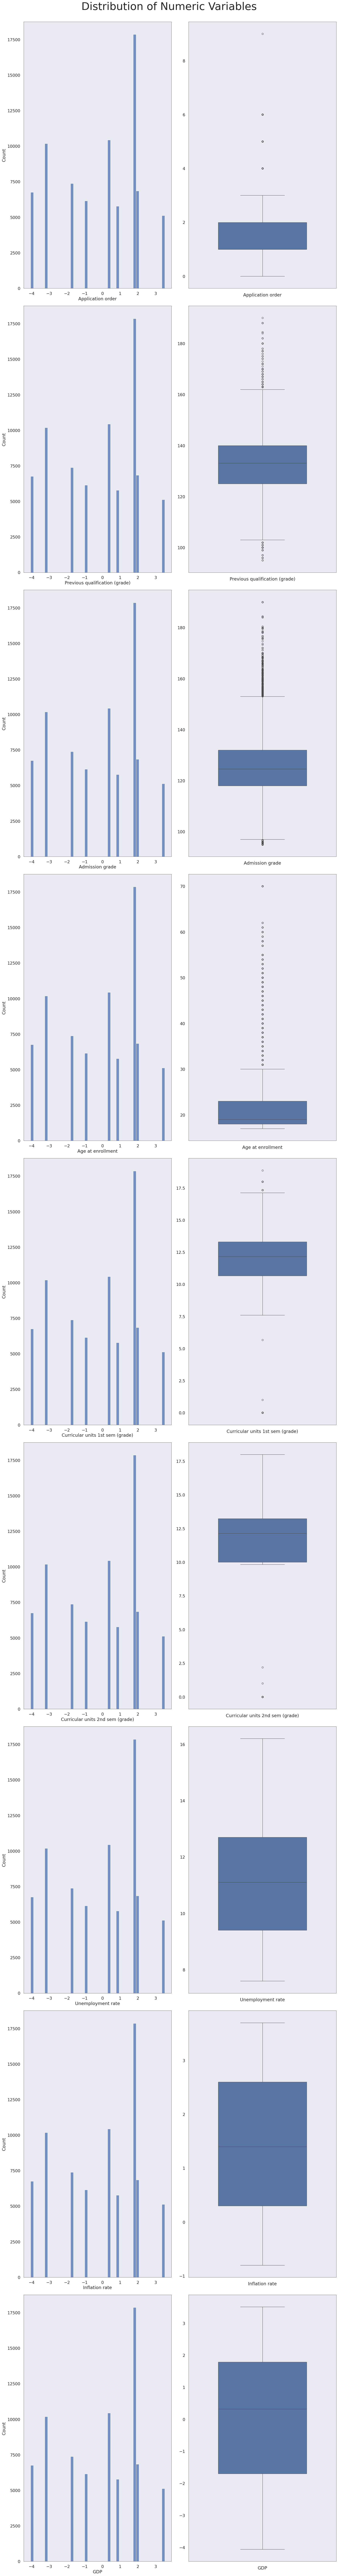

In [ ]:
plt.figure(figsize=(18, 135))
plotnumber = 1

for col in num_cols:
    if plotnumber <= len(num_cols):

        ax1 = plt.subplot(len(num_cols), 2, 2 * plotnumber - 1)
        sns.histplot(train[column])
        for spine in ax1.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        ax1.set_xlabel(col)
        ax1.grid(False)

        ax2 = plt.subplot(len(num_cols), 2, 2 * plotnumber)
        sns.boxplot(y=train[col], width=0.6, linewidth=1)
        for spine in ax2.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        ax2.set_xlabel(col)
        ax2.set_ylabel('')
        ax2.grid(False)

    plotnumber += 1

plt.suptitle('Distribution of Numeric Variables', fontsize=40, y=1)
plt.tight_layout()
plt.show()

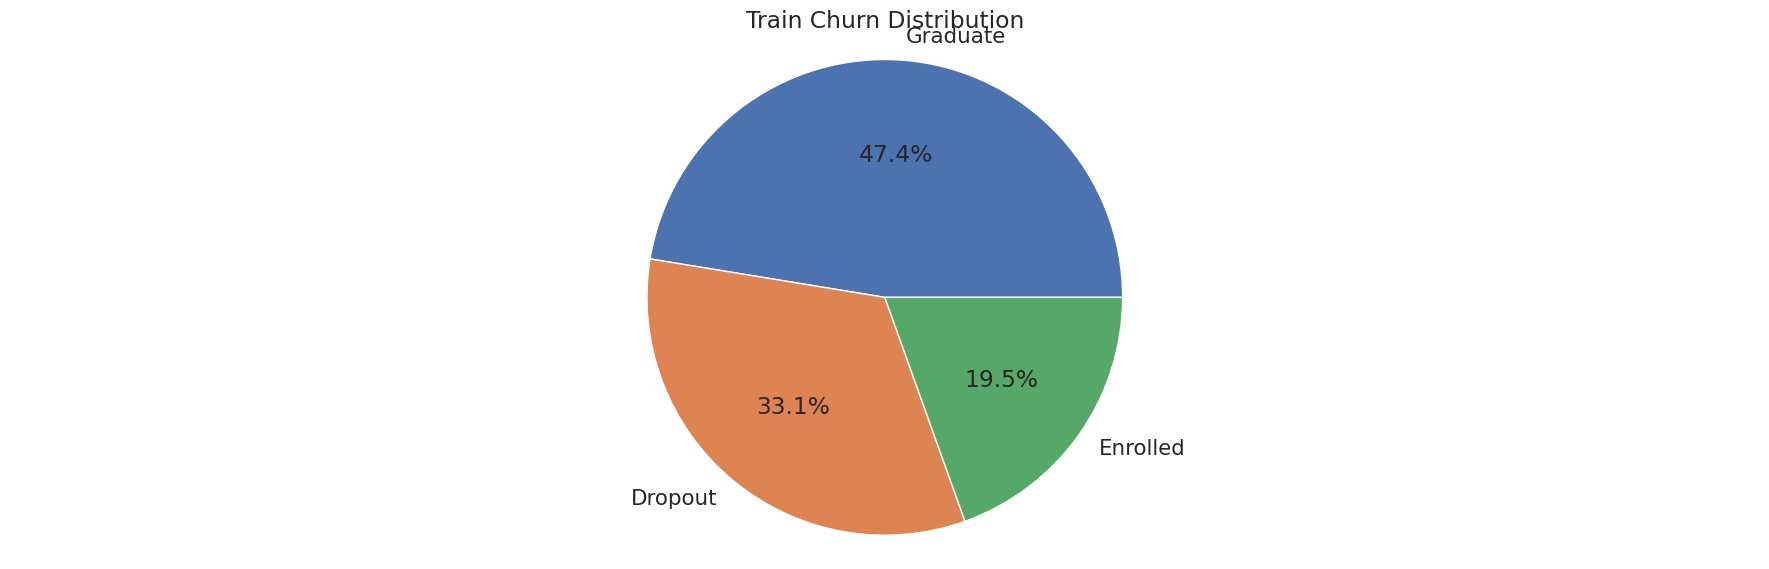

In [ ]:
def plot_pie_chart(data, title, ax):
    data_counts = data[target].value_counts()
    labels = data_counts.index
    sizes = data_counts.values

    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(title)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot()

plot_pie_chart(train_copy, "Train Churn Distribution", ax)

plt.tight_layout()
plt.show()

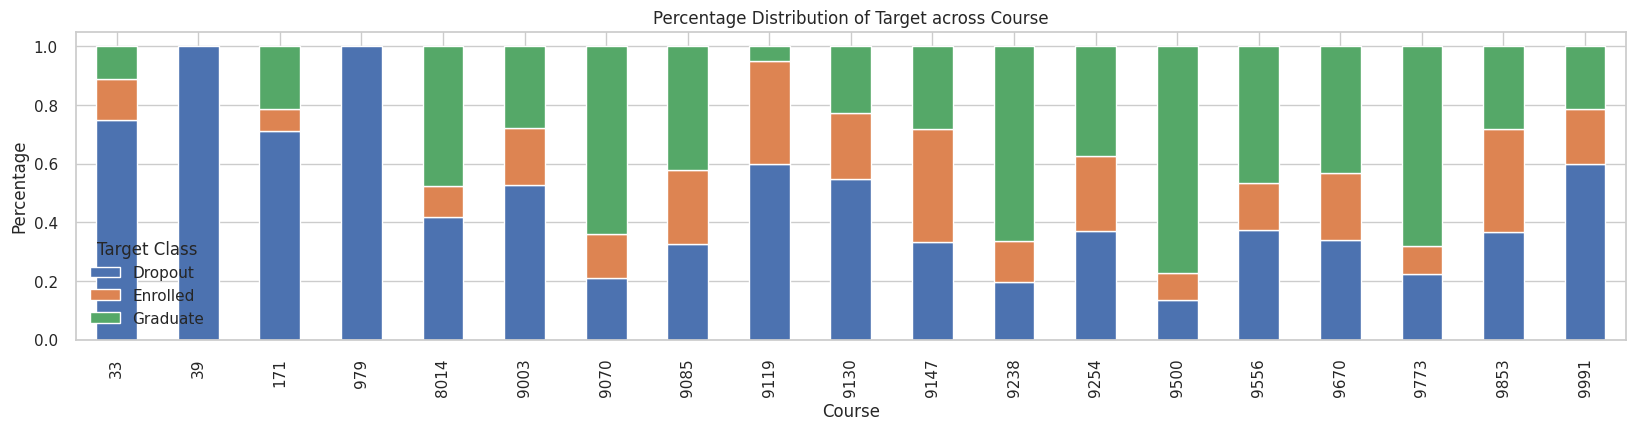

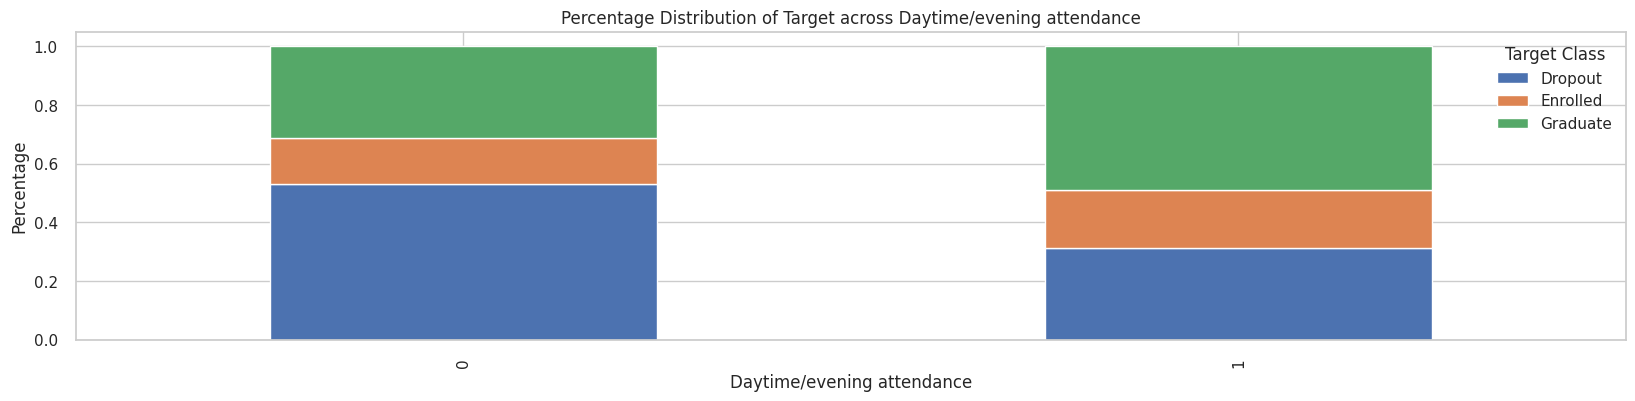

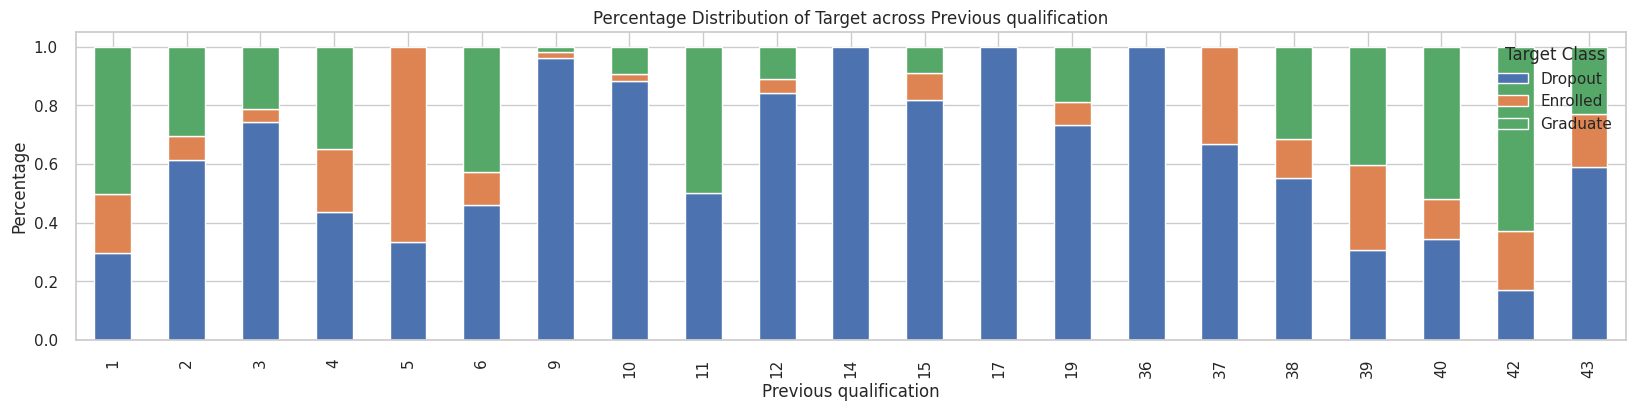

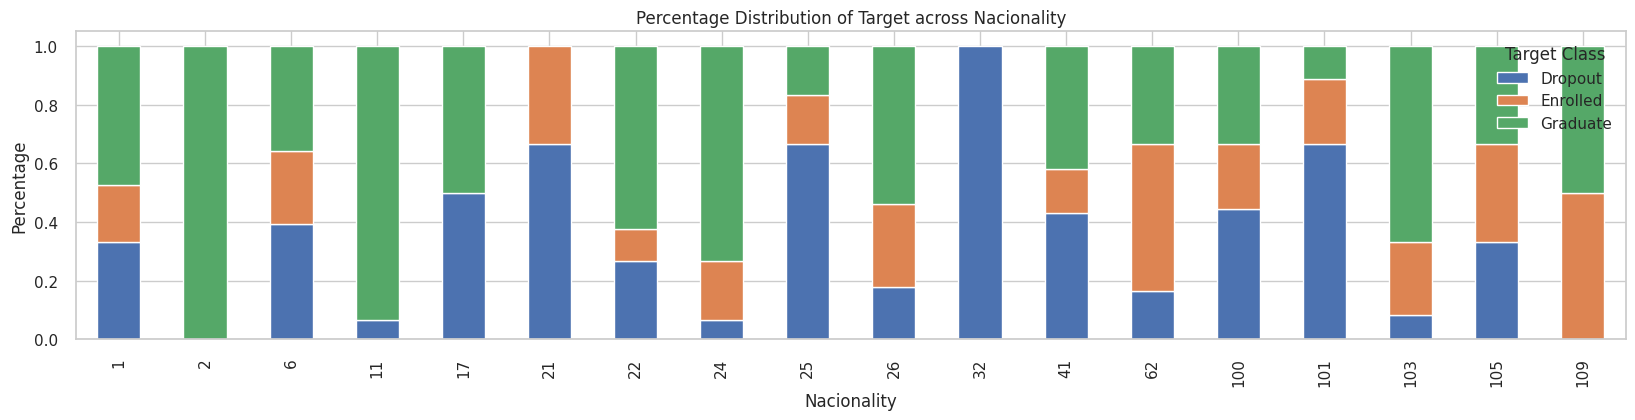

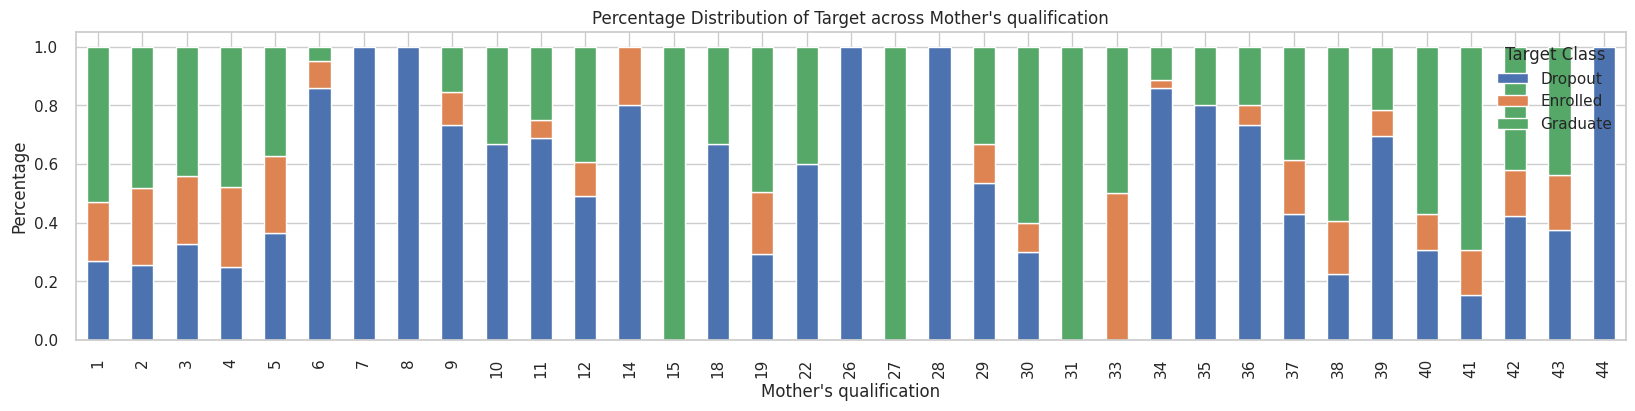

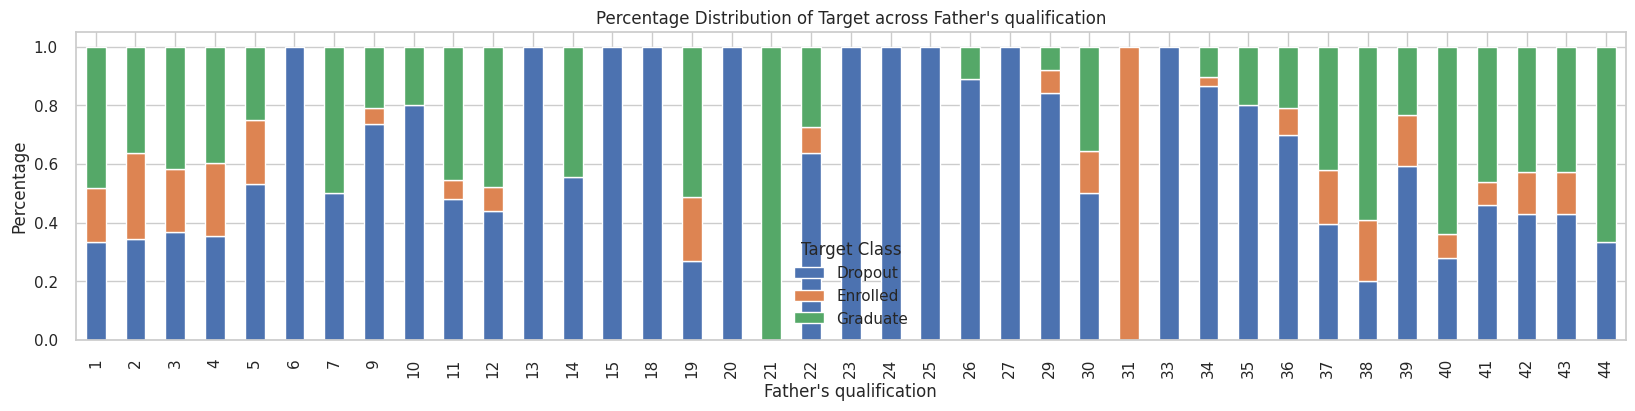

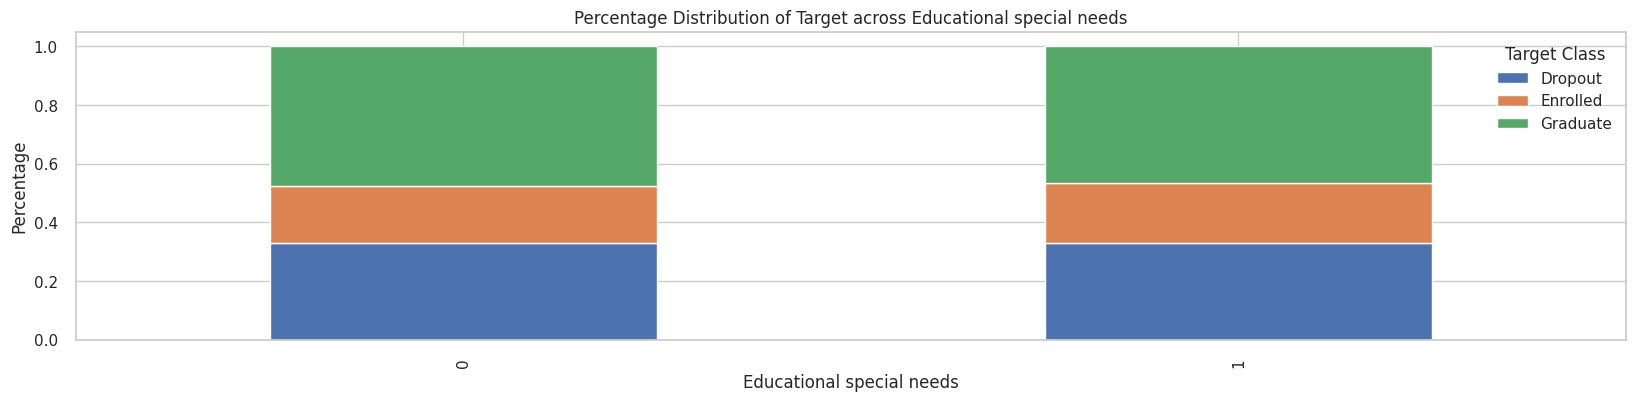

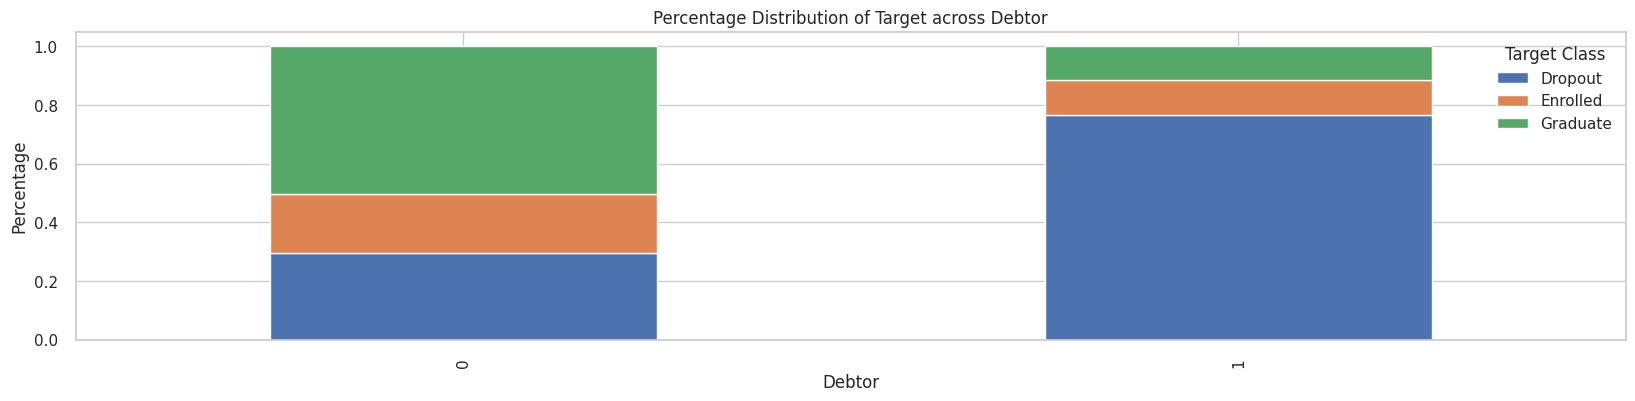

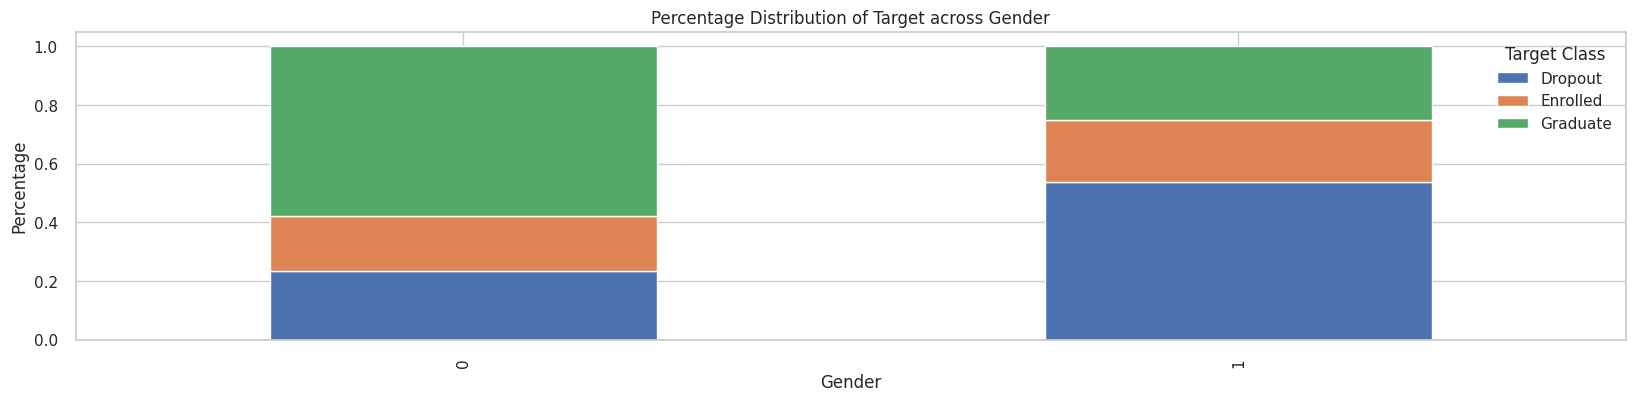

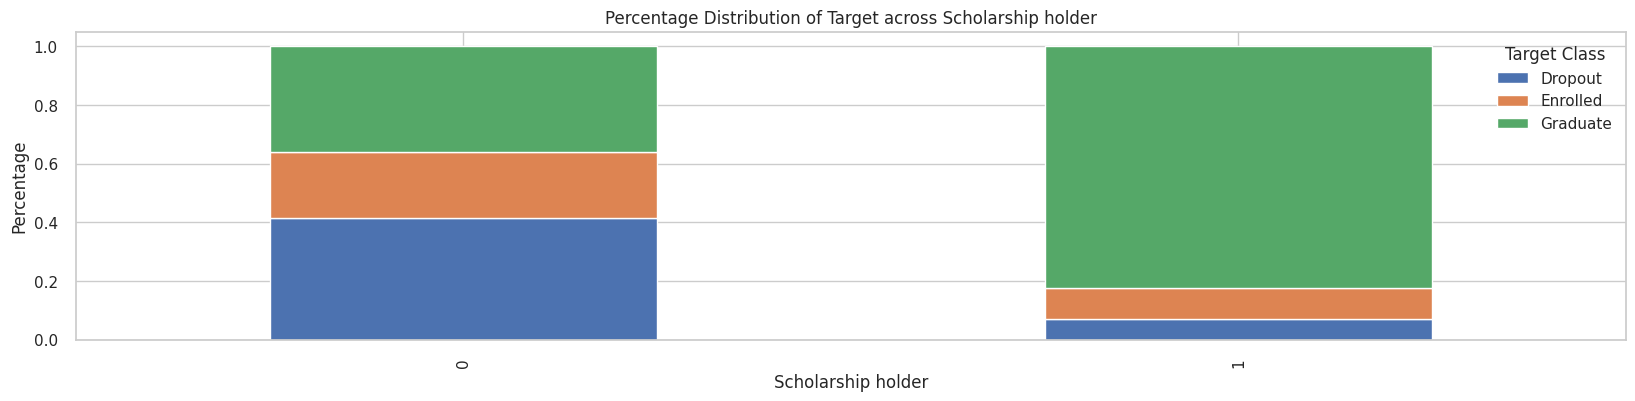

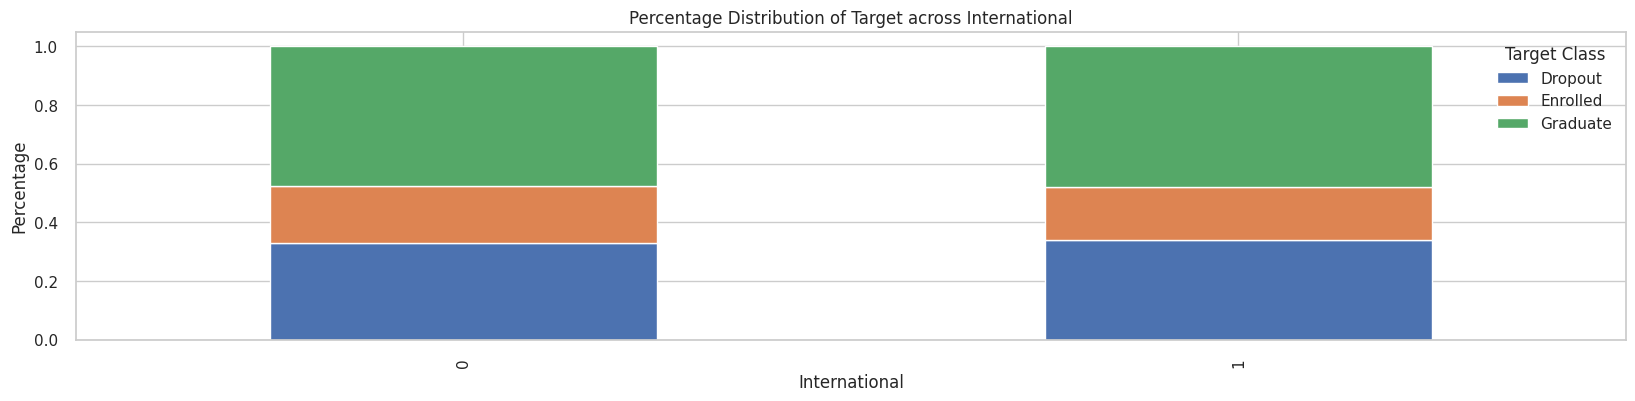

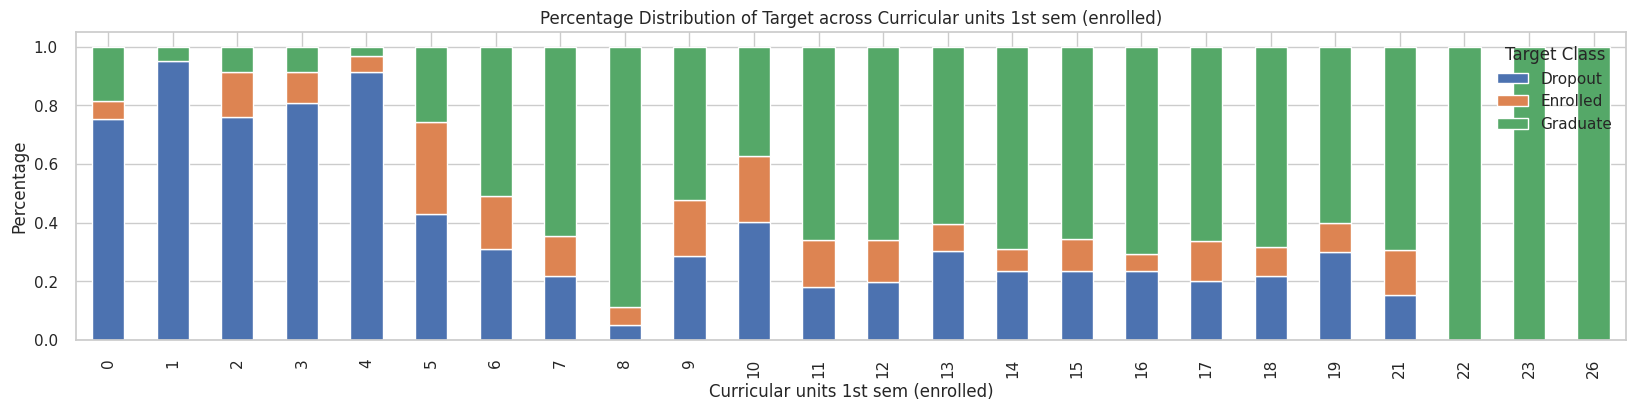

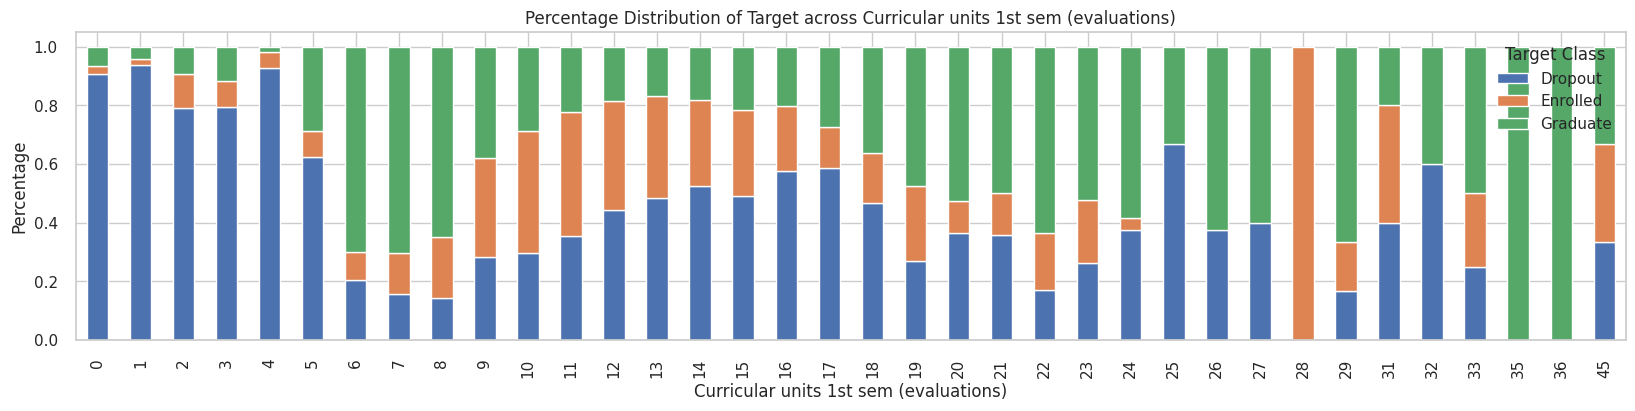

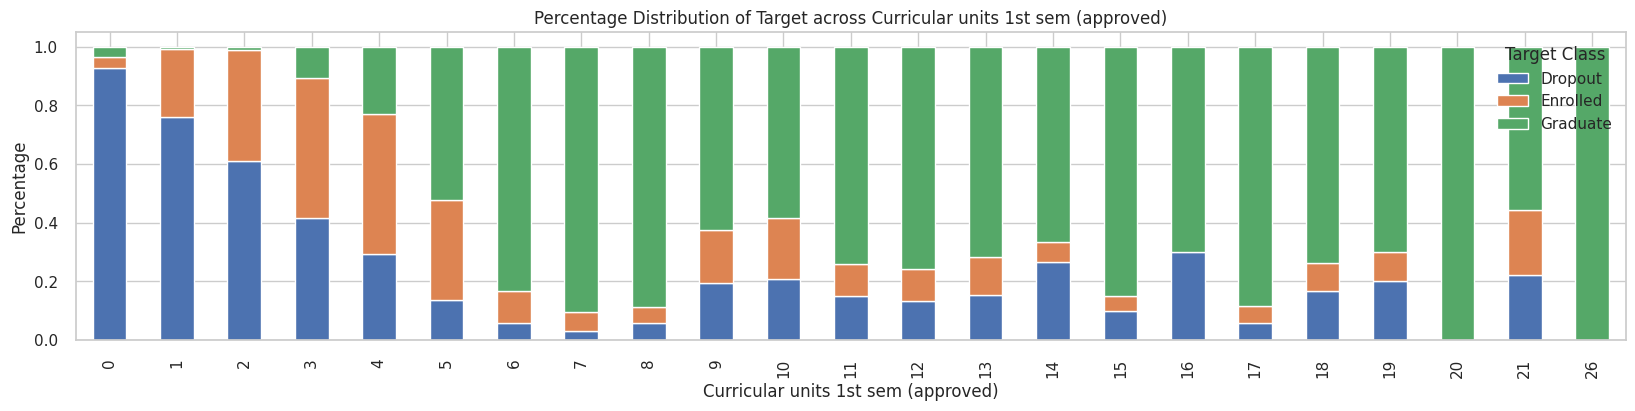

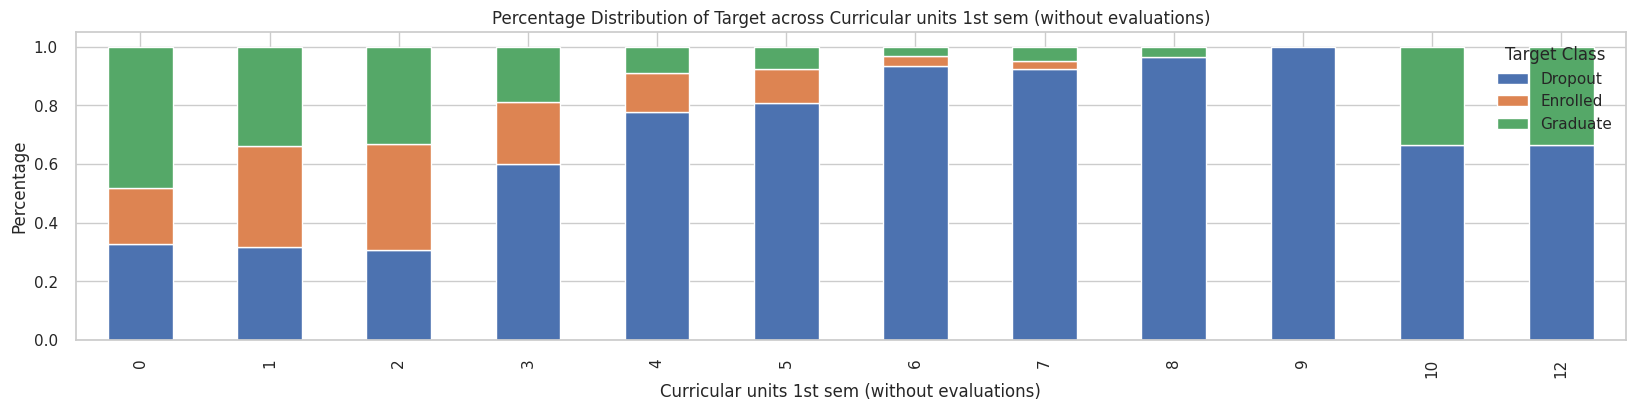

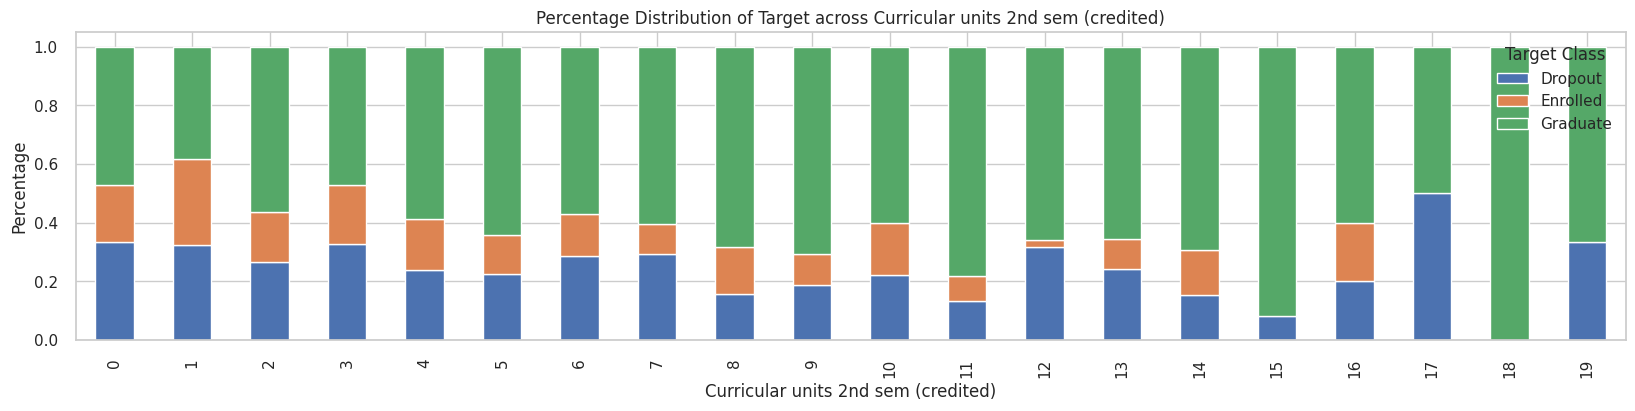

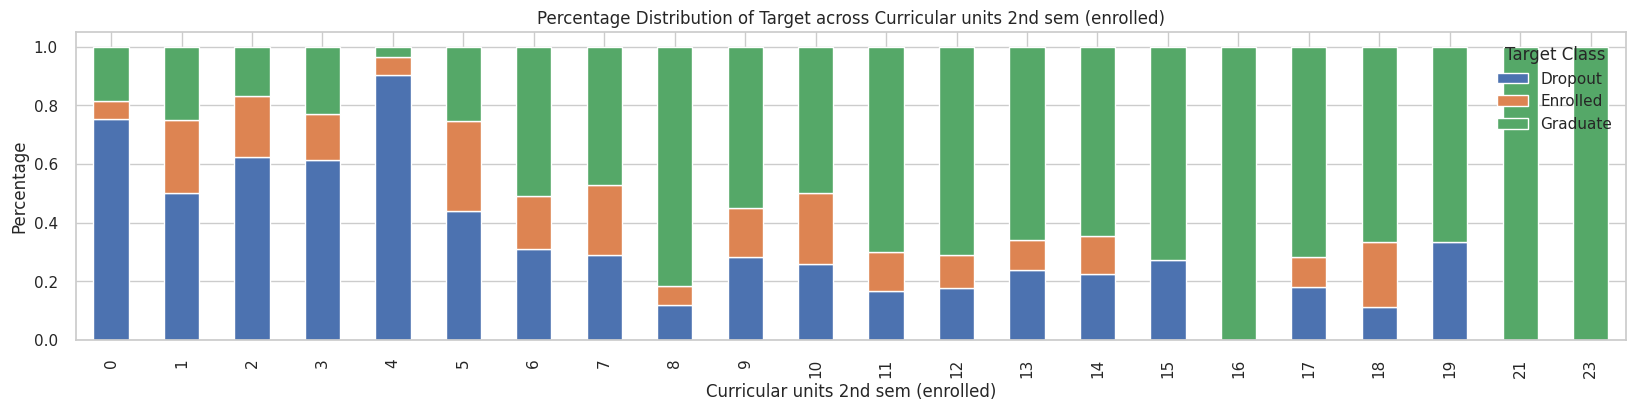

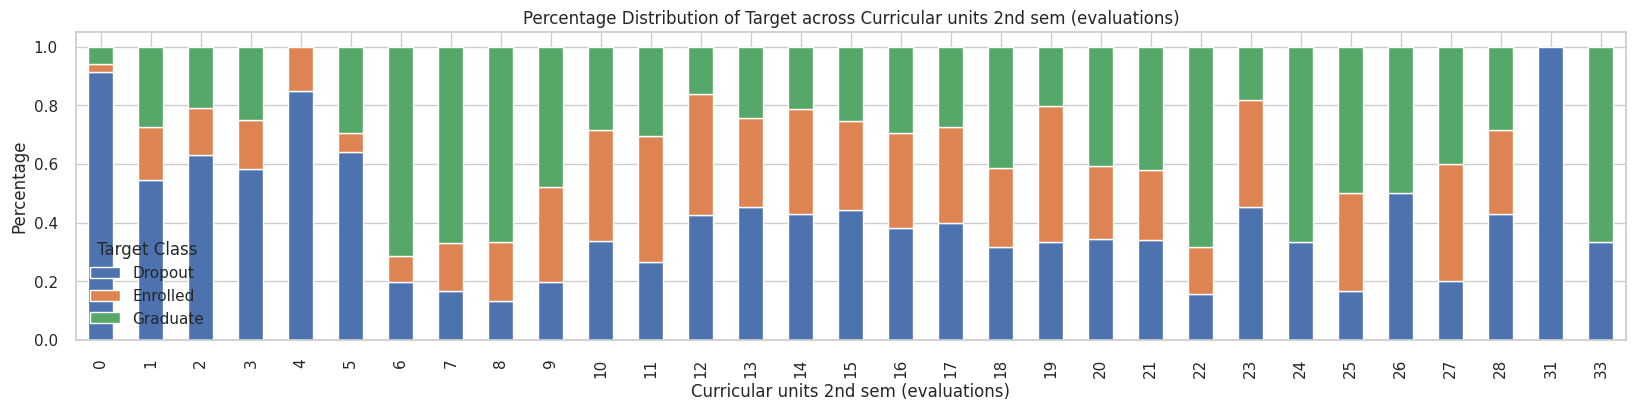

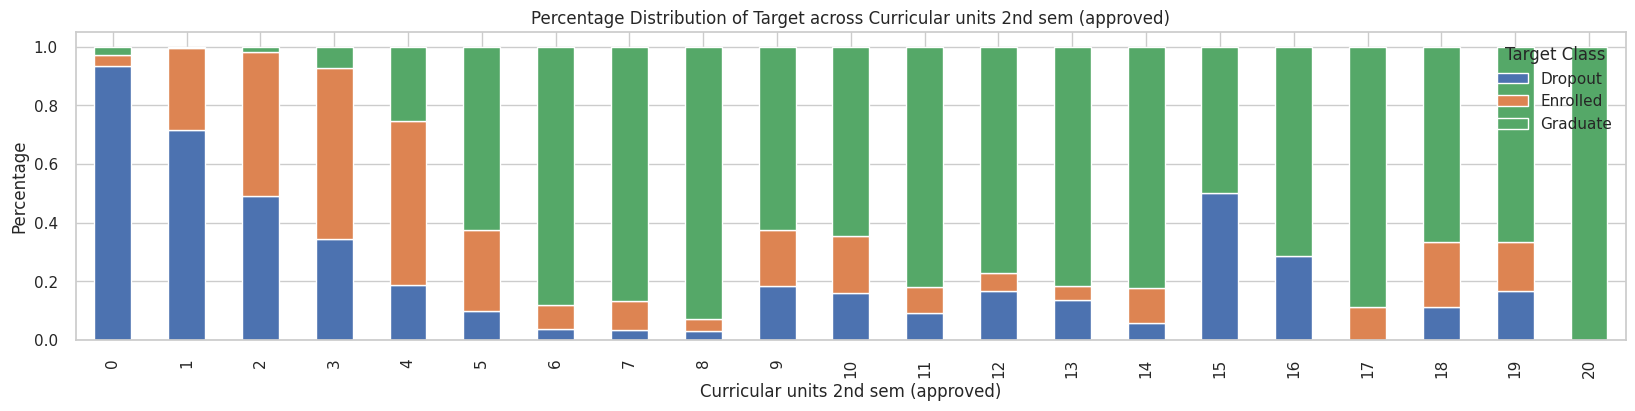

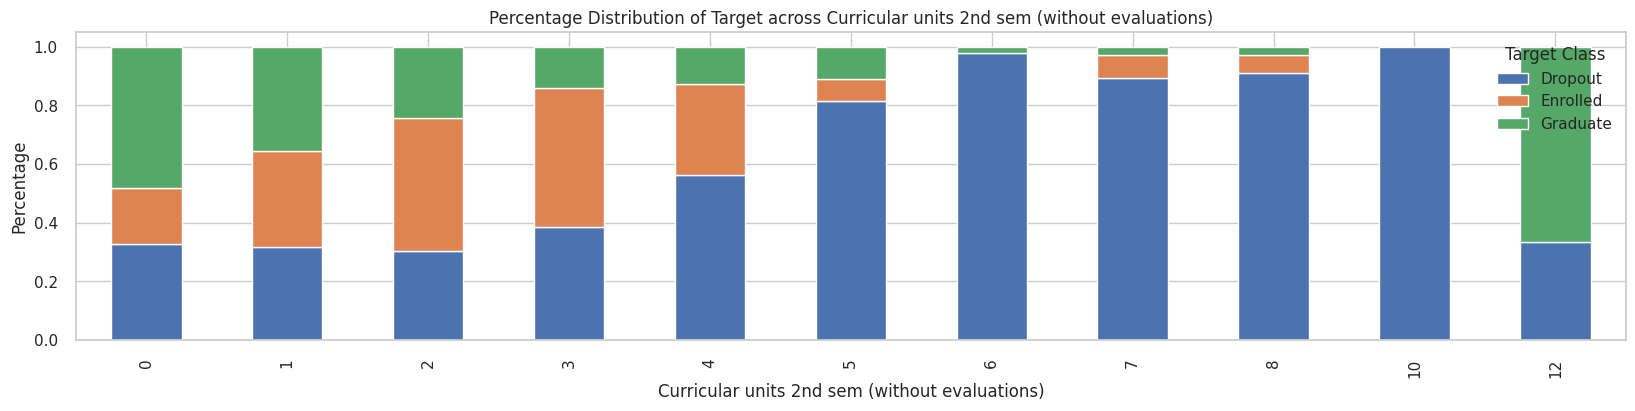

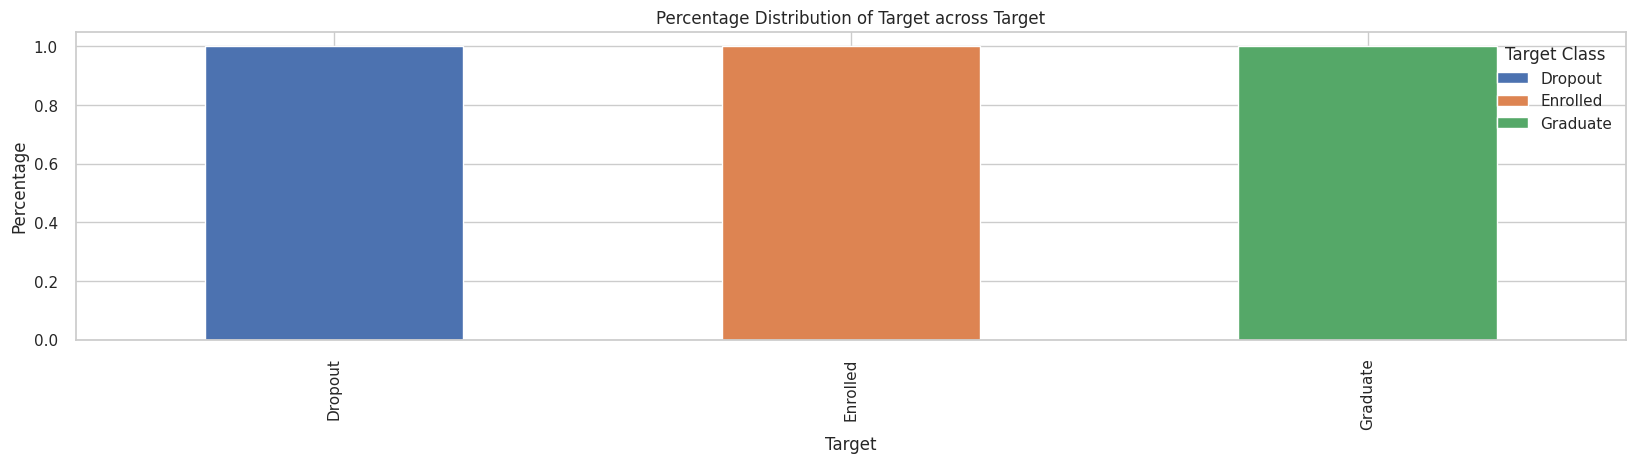

In [ ]:
for col in cat_cols:
    contingency_table = pd.crosstab(train[col], train[target], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Target Class")
    plt.show()